In [1]:
#from desc import set_device
#set_device("gpu")

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [9]:
import numpy as np
import os

from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
#from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import flatten_list, Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif, cross, dot

from desc.optimize import lsqtr, lsq_auglag

from desc.magnetic_fields import FourierCurrentPotentialField

import time

import numpy as np
from numpy import ndarray

from desc.fns_simp import (plot_figure,
                           plot_figure2,
                            plot_xy,
                           surf_int,
                           _compute_magnetic_field_from_Current)

from desc.objectives.sources_dipoles_utils import iso_coords_load, iso_coords_interp, alt_grid

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

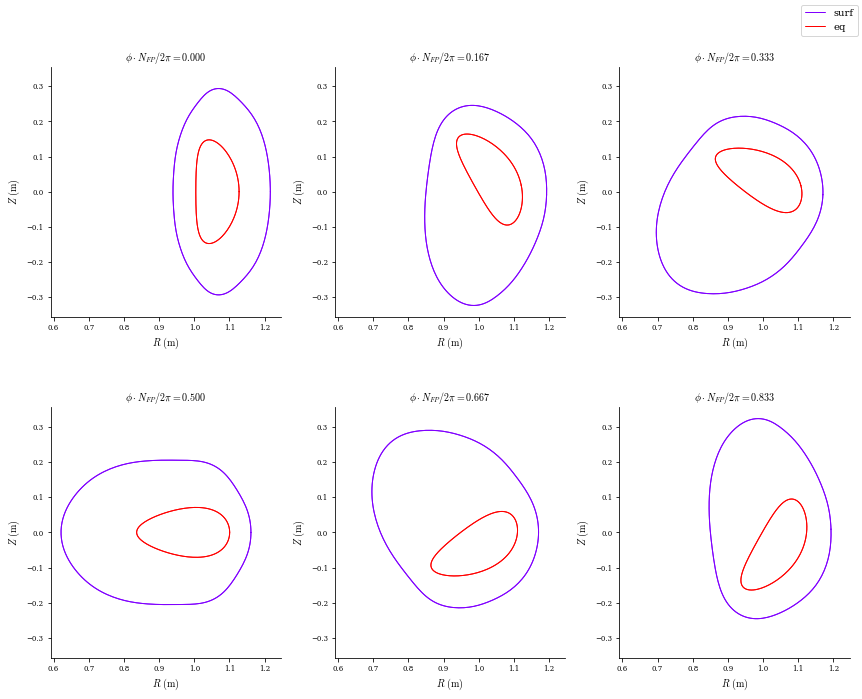

In [10]:
# Plasma surfaces
#eqname_QA = "/scratch/gpfs/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eqname_QA = "input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eq = eq_QA

name = './iso_coords/'
# Winding surfac./e
surf_winding = load(name + "surf.h5")

# Plot both surfaces
plot_comparison([surf_winding,eq],labels=["surf","eq"],theta=0,rho=np.array(1.0))

In [11]:
tdata = iso_coords_load(name,surf_winding)

In [17]:
# Evaluate Green's function for flat tori
sgrid = LinearGrid(M = 120, N = 120,
                   NFP = surf_winding.NFP,
                  )
sdata = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s",'x'], grid = sgrid)
sdata = iso_coords_interp(tdata, sdata, sgrid,)

G = np.load(name + "G.npy")
K_sec = G * cross(sdata["n_rho"], sdata["e^u_s"])
K_sv = surf_winding.compute(["K"],grid = sgrid)["K"]

In [14]:
sgrid2 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*1)).T
                    )
sgrid3 = Grid(nodes = jnp.vstack((sgrid.nodes[:,0],
                                        sgrid.nodes[:,1],
                                        sgrid.nodes[:,2] + (2*np.pi/surf_winding.NFP)*2)).T
                    )

sdata2 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s",'x'], grid = sgrid2)
sdata2 = iso_coords_interp(tdata, sdata2, sgrid2)

sdata3 = surf_winding.compute(["theta","zeta", "e^theta_s","e^zeta_s",'x'], grid = sgrid3)
sdata3 = iso_coords_interp(tdata, sdata3, sgrid3)

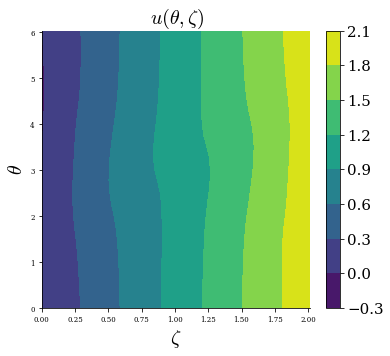

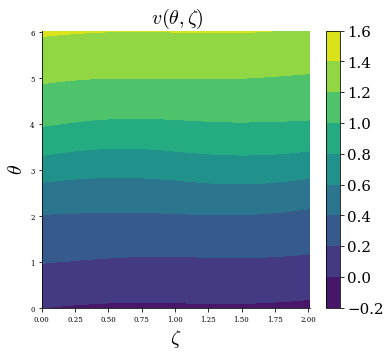

In [15]:
# Confirm that variables have the same shape
plot_figure2(sdata["u_iso"],sgrid,''r' $ u(\theta,\zeta)$ ')
plot_figure2(sdata["v_iso"],sgrid,''r' $ v(\theta,\zeta)$ ')
#plot_figure2(sdata["lambda_iso"],sgrid,''r' $ \lambda $ ')

#plot_figure2(sdata2["u_iso"],sgrid2,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata2["v_iso"],sgrid2,''r' $ v(\theta,\zeta)$ ')

#plot_figure2(sdata3["u_iso"],sgrid3,''r' $ u(\theta,\zeta)$ ')
#plot_figure2(sdata3["v_iso"],sgrid3,''r' $ v(\theta,\zeta)$ ')

In [18]:
eps = 1e-2
dt = eps
dz = eps
d0 = eps/3

In [19]:
grid_M = 20
grid_N = 20

In [20]:
egrid = LinearGrid(M = grid_M, N = grid_N, NFP = eq.NFP)
edata = eq.compute(["n_rho","B"], grid = egrid)

#B_s = edata["B"]
B_sec = np.load('iso_coords/B_sec_'+str(grid_M)+'x'+str(grid_N)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
B_s = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid, basis = "rpz" )
#B_s = _compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid, basis = "rpz" )
rhs = jnp.concatenate((B_s[:,0],B_s[:,1],B_s[:,2],
                      jnp.asarray([0])))
#- dot( edata["n_rho"],  B_sec )

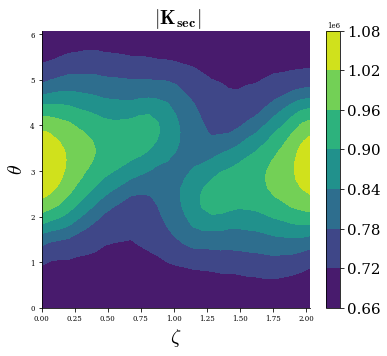

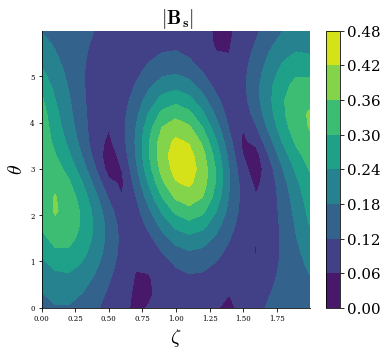

In [21]:
plot_figure2( dot(K_sec,K_sec) ** (1/2), sgrid,''r' $ | \mathbf{K_{sec}} |$ ')
plot_figure2( dot(B_s,B_s) ** (1/2), egrid,''r' $ | \mathbf{B_{s}} |$ ')
#plot_figure2( rhs, egrid, ''r' $ \mathbf{B_{sec} \cdot n}$ ' )

In [22]:
N = 20 # Terms toa pproximate the infinite series

# Numer of dipoles
sMv = np.asarray([30,]) # Poloidal direction
sNv = np.asarray([30,]) # Toroidal direction

In [23]:
p_M = sMv[0]
p_N = sNv[0]

In [24]:
grid_M2 = grid_M
grid_N2 = grid_N

egrid2 = LinearGrid(M = grid_M2, N = grid_N2, NFP = eq.NFP)
edata2 = eq.compute(["n_rho"], grid = egrid2)

B_sec2 = np.load('iso_coords/B_sec_'+str(grid_M2)+'x'+str(grid_N2)+'.npy')
#_compute_magnetic_field_from_Current( sgrid, K_sec, surf_winding, eq, egrid2, basis = "rpz" )
B_s2 = _compute_magnetic_field_from_Current( sgrid, K_sv, surf_winding, eq, egrid2, basis = "rpz" )
#B_s2 = edata2["B"]

In [25]:
from desc.magnetic_fields._sinkssources import SinksSources
sinks_sources_basis = SinksSources(p_M=p_M,p_N=p_N, NFP = surf_winding.NFP)

In [26]:
#Generate the grid for the controus on the winding surface

theta_coarse = jnp.linspace(
        2 * jnp.pi * (1 / (p_M * 2+1)) * 1 / 2,
        2 * jnp.pi * (1 - 1 / (p_M * 2+1) * 1 / 2),
        p_M * 2+1,
    )

zeta_coarse = jnp.linspace(
            2 * jnp.pi / sinks_sources_basis.NFP * (1 / (p_N * 2+1)) * 1 / 2,
            2 * jnp.pi / sinks_sources_basis.NFP * (1 - 1 / (p_N * 2+1) * 1 / 2),
            p_N * 2+1,
        )
    
# Refine the grid to do the contour integration of the poloidal wires
add_points = 5 # TODO: Make this a control variable in the inputs of this object
from desc.objectives.sources_dipoles_utils import densify_linspace, alt_grid_sticks, compute_mask
theta_contour = densify_linspace(theta_coarse, points_per_interval=add_points)
zeta_contour = zeta_coarse  # no need to refine zeta positions since these are fixed during the integration
    
#assert (p_M * 2 + 1) * (p_N * 2 + 1) == theta_coarse.shape[0] * zeta_coarse.shape[0], "Check that the sources coincide with the number of sources/sinks"
#r = theta_coarse.shape[0] * zeta_coarse.shape[0]  # ss_data["theta"].shape[0]
#r_t = theta_coarse.shape[0]
#r_z = zeta_coarse.shape[0]
    
contour_grid = alt_grid_sticks(theta_contour, zeta_contour, sgrid)

contour_data = surf_winding.compute(["theta", "zeta", "e_theta",'x'],grid = contour_grid)

In [27]:
sign_vals = jnp.where(contour_data["theta"] < jnp.pi, -1, 1) #+ jnp.where(ss_data["theta"] > jnp.pi, 1, 0)
A = compute_mask(contour_data, theta_coarse, zeta_coarse)
AA = A[:, None, :] * contour_data['e_theta'][:, :, None]
AAA = AA * ( jnp.sum(contour_data["e_theta"] * contour_data["e_theta"], axis = 1 ) ** (-1 / 2) * sign_vals )[:, None, None]

In [18]:
# Generate the grid for the sticks

# These are the sticks that are all located at the (theta = pi) cut
theta = jnp.pi * jnp.ones_like(theta_coarse)
stick_grid = alt_grid_sticks(theta, zeta_coarse, sgrid)
stick_data = surf_winding.compute(["theta", "x"], grid = stick_grid)

In [19]:
# Find info of the isothermal coordinates at the locations of the sources
ss_grid = alt_grid(theta_coarse, zeta_coarse)
ss_data = surf_winding.compute(["theta", "zeta", "e^theta_s", "e^zeta_s",
                                "x",], 
                               grid = ss_grid)
        
ss_data = iso_coords_interp(tdata, ss_data, ss_grid)

In [20]:
coords = eq.compute(["x"], grid = egrid)['x']

In [ ]:
coords.shape[0]

In [21]:
from mpi4py import MPI
from desc.objectives.find_sour_mpi_xy import bn_res_vec_mpi_2d #as bn_res_vec_orig

def main():
    # --- MPI setup ---
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    if rank == 0:
        print(f"Running MPI Biot-Savart with {size} ranks (CPU-only)")

    # --- Compute local slice ---
    local_result = bn_res_vec_mpi_2d(
        sdata, sdata2, sdata3, sgrid, surf_winding, N, d0, coords,
        tdata, contour_data, stick_data, contour_grid, ss_data, AAA,
        mpi_comm=comm
    )

    # --- Synchronize all ranks before gathering ---
    comm.Barrier()

    # --- Gather results to rank 0 ---
    all_chunks = comm.gather(local_result, root=0)

    if rank == 0:
        # Concatenate along the last axis (targets)
        B_total = np.concatenate(all_chunks, axis=-1)
        print("Fully assembled B_total.shape =", B_total.shape)

        # Optional: compute pseudoinverse
        # B_pinv = np.linalg.pinv(B_total)
        # print("B_pinv.shape =", B_pinv.shape)
    else:
        B_total = None

    # Broadcast full B_total to all ranks if needed
    # B_total = comm.bcast(B_total, root=0)

    return B_total if rank == 0 else None

if __name__ == "__main__":
    B_total = main()

In [23]:
#import jax
#import jax.numpy as jnp
#import time

# Create large test matrix
#A = jnp.ones((40000, 8000))#, dtype=jnp.float32)

# Force CPU device (optional)
#A = jax.device_put(A, jax.devices("cpu")[0])

#start = time.time()
#A_pinv = jnp.linalg.pinv(A).block_until_ready()
#print(f"Computed pseudo-inverse in {time.time() - start:.2f} seconds")